In [1]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior, hnn_noise_conn_prob_param_function,
                   load_posterior, simulator_hnn, get_dataset_psd, get_dataset_bandpower,
                   get_parameter_recovery, get_posterior_predictive_check, PriorBetaFiltered)
from viz import plot_spikes_raster
from hnn_core import jones_2009_model, calcium_model
from hnn_core.check import _gid_to_type
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.timefrequency.wavelets import compute_wavelet_transform


rng_seed = 123
rng = np.random.default_rng(rng_seed)

scale_factor = 60_000

# sns.set()
# sns.set_style("white")

device = 'cpu'

data_path = '/expanse/lustre/scratch/ntolley/temp_project/beta_tuning'

# with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
#     posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)

dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
gid_ranges = sim_metadata['gid_ranges']
gid_to_type = partial(_gid_to_type, gid_ranges=gid_ranges)
# extra_dict = posterior_metadata['extra_dict']
# window_samples = extra_dict['window_samples'] 
theta_extra = sim_metadata['theta_extra']

dpl = np.load(f'{data_path}/sbi_sims/dpl_sbi.npy')
theta = np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
spike_gids = np.load(f'{data_path}/sbi_sims/spike_gids_sbi.npy', allow_pickle=True)
spike_times = np.load(f'{data_path}/sbi_sims/spike_times_sbi.npy', allow_pickle=True)

times = np.linspace(0, 1, dpl.shape[1])
mask = times > 0.2 # burn in time
fs = 1000 / dt

net = calcium_model()

--No graphics will be displayed.


(0.16005250000000001, 1.0399975, -7.440582611789333, 41.52972254874268)

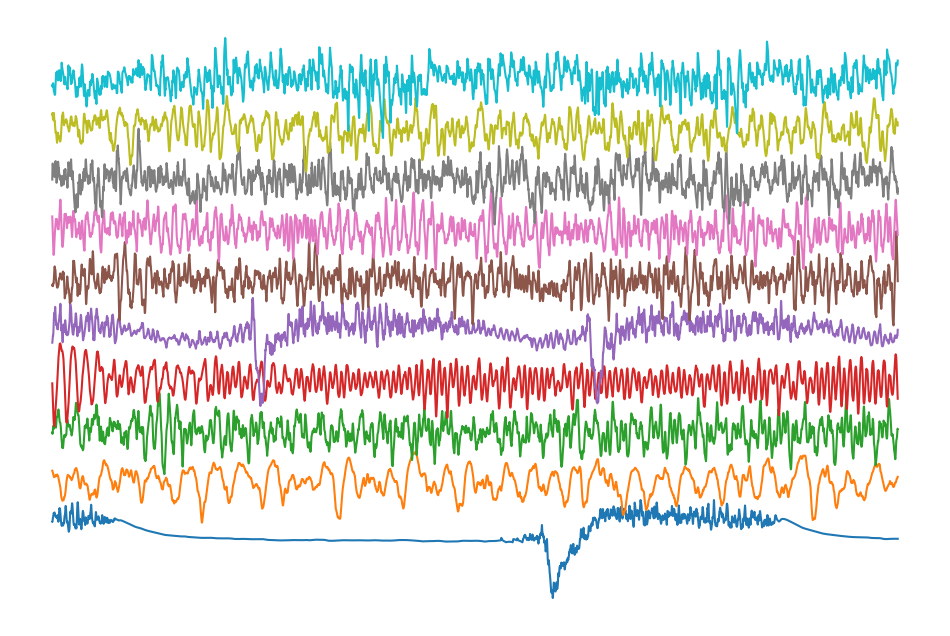

In [63]:
plt.figure(figsize=(12,8))
for sim_idx in range(10):
    sig = dpl[sim_idx, mask] - np.mean(dpl[sim_idx, mask])
    sig = sig / np.std(sig)
    _ = plt.plot(times[mask], sig + (4 * sim_idx))
# plt.xlabel('Time (s)', fontsize=15)
# plt.ylabel('Dipole', fontsize=15)
plt.axis('off')

In [64]:
freqs, powers = compute_spectrum(dpl[:, mask], fs, method='welch', avg_type='median')
freqs, powers = trim_spectrum(freqs, powers, [0, 100])

/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 20000 is greater than input length  = 16000, using nperseg = 16000
  warnings.warn('nperseg = {0:d} is greater than input length '


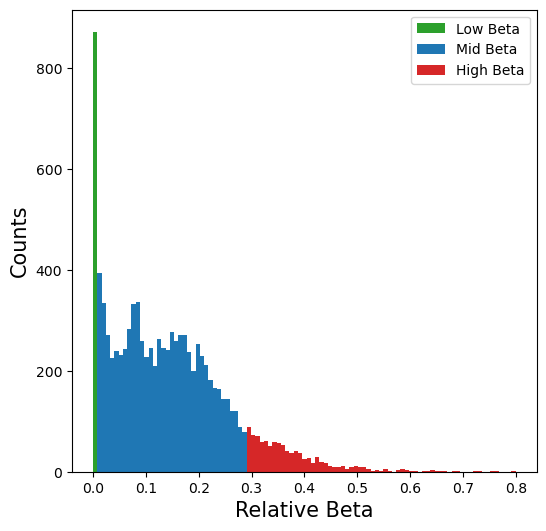

In [166]:
beta_mask = (freqs > 13) & (freqs < 30)
beta_power = powers[:, beta_mask].sum(axis=1)
beta_ratio = beta_power / powers.sum(axis=1)
ratio_sort = np.argsort(beta_ratio)[::-1]

cutoff = 1000

bins = np.linspace(0, 0.8, 100)

plt.figure(figsize=(6,6))
_ = plt.hist(beta_ratio[ratio_sort[-cutoff:]], bins=bins, color='C2', label='Low Beta')
_ = plt.hist(beta_ratio[ratio_sort[cutoff:-cutoff]], bins=bins, color='C0', label='Mid Beta')
_ = plt.hist(beta_ratio[ratio_sort[:cutoff]], bins=bins, color='C3', label='High Beta')

plt.xlabel('Relative Beta', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend()


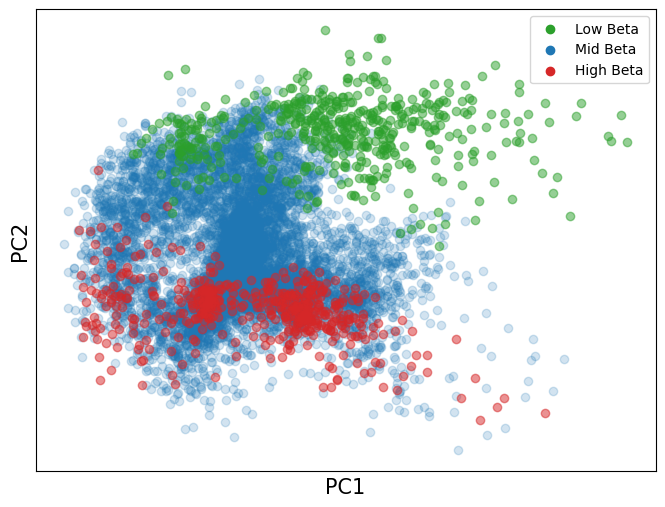

In [122]:
pca = PCA(n_components=len(freqs))
pca_powers = pca.fit_transform(np.log(powers))

plt.figure(figsize=(8, 6))
# plt.scatter(pca_powers[:,0], pca_powers[:,1], alpha=0.2)
plt.scatter(pca_powers[ratio_sort[cutoff:-cutoff],0], pca_powers[ratio_sort[cutoff:-cutoff],1], color='C0', alpha=0.2)
plt.scatter(pca_powers[ratio_sort[:cutoff],0], pca_powers[ratio_sort[:cutoff],1], color='C3', alpha=0.5)
plt.scatter(pca_powers[ratio_sort[-cutoff:],0], pca_powers[ratio_sort[-cutoff:],1], color='C2', alpha=0.5)

plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.xticks([])
plt.yticks([])

plt.scatter([1e10], [1e10], color='C2', label='Low Beta')
plt.scatter([1e10], [1e10], color='C0', label='Mid Beta')
plt.scatter([1e10], [1e10], color='C3', label='High Beta')

plt.legend()


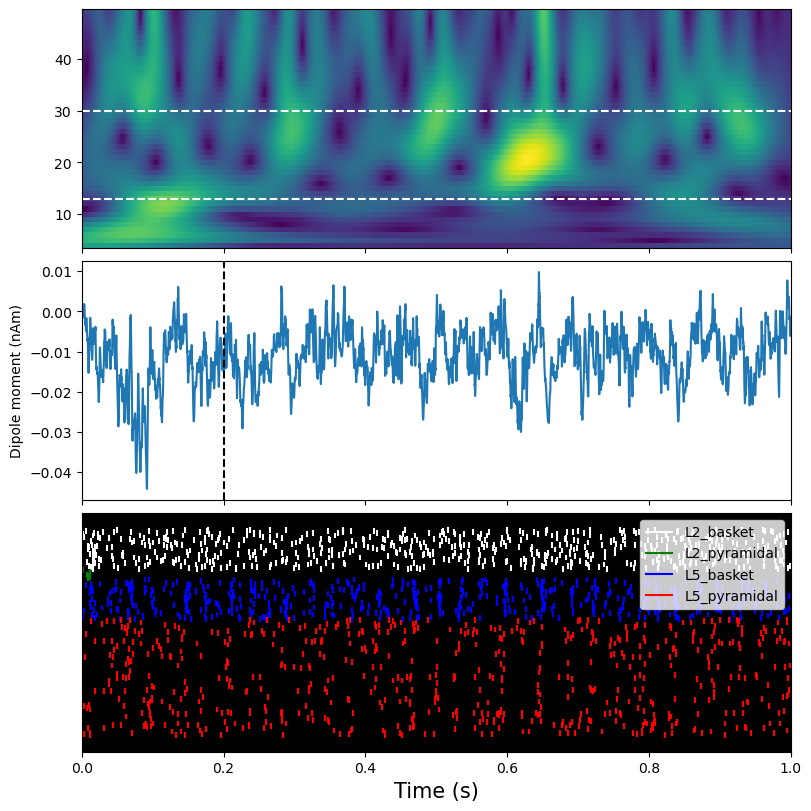

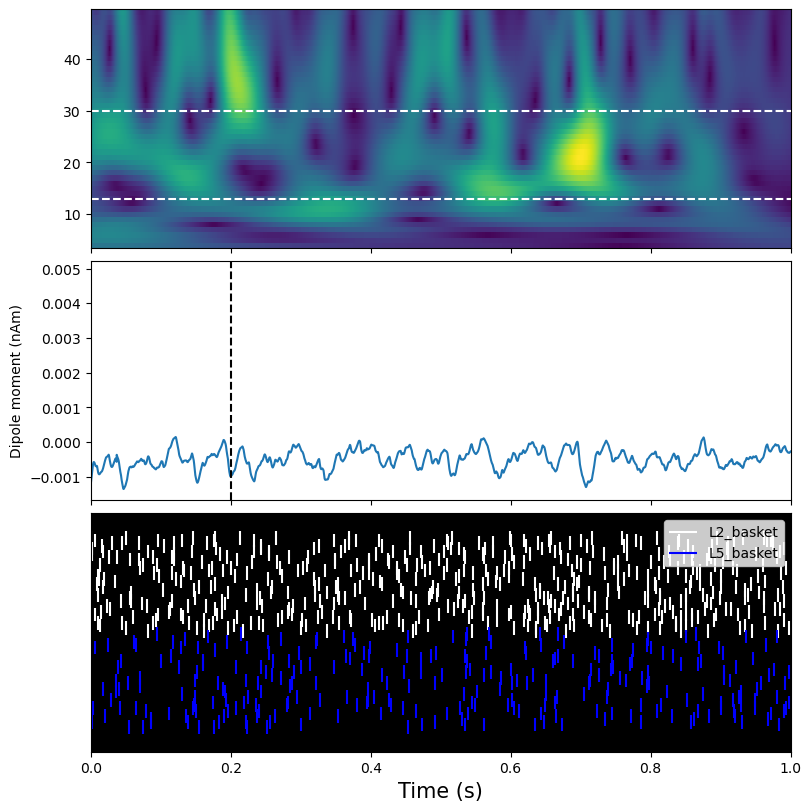

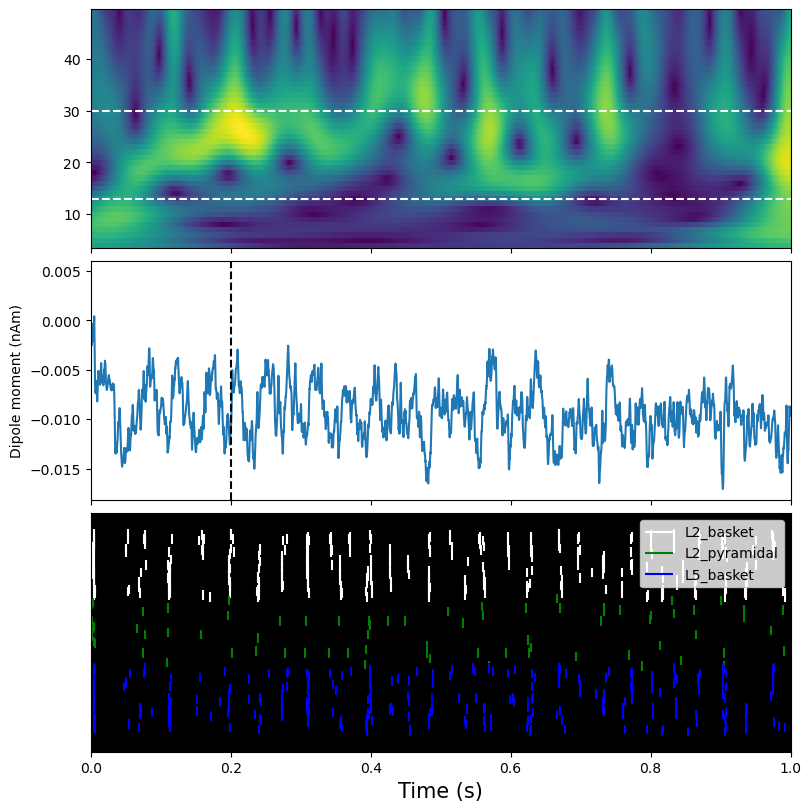

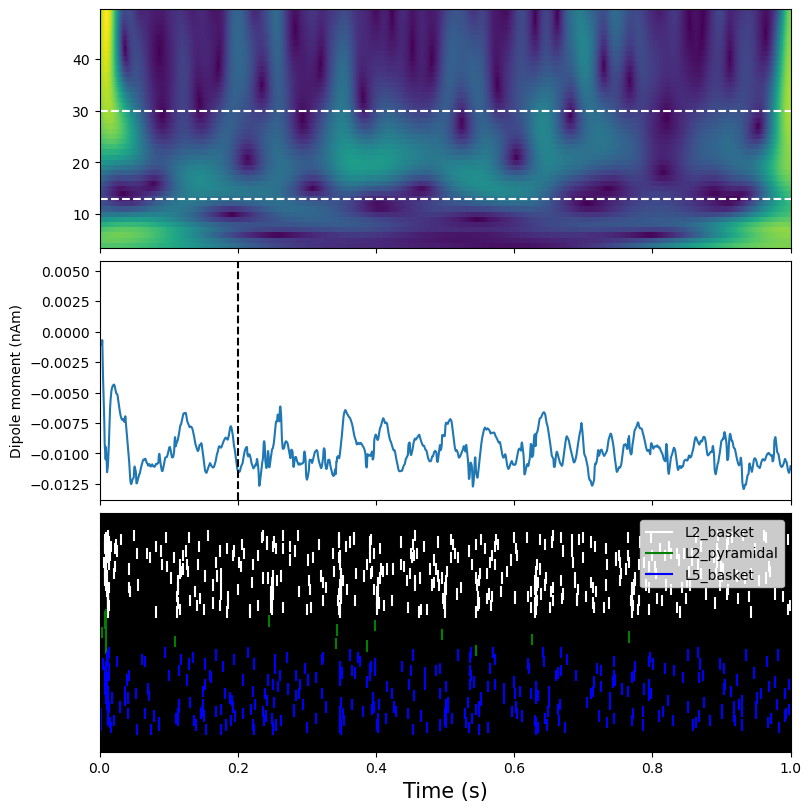

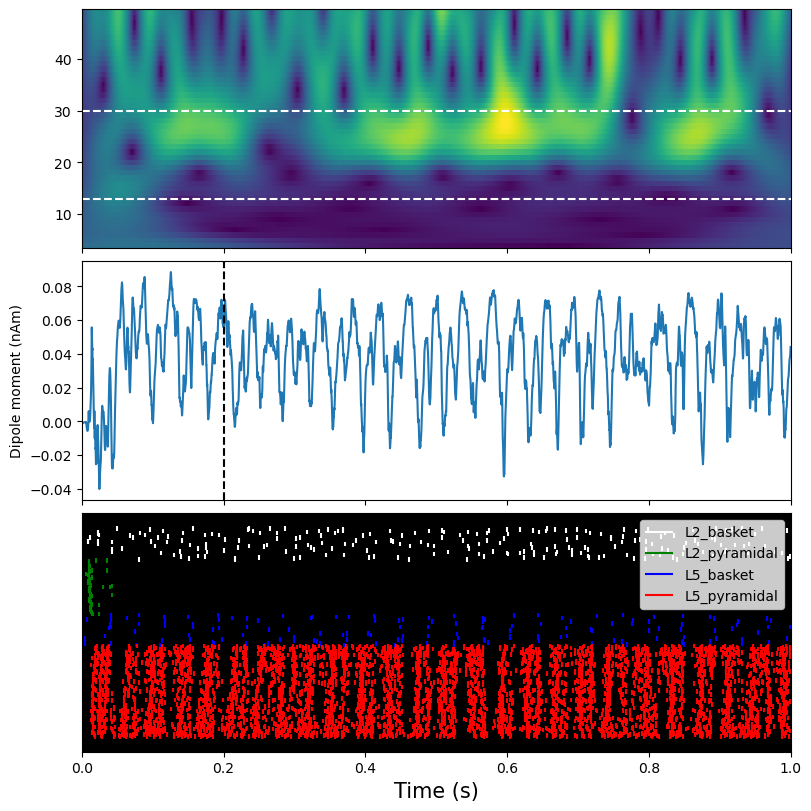

In [9]:
freqs = np.arange(4,50,1)
x_tick_pos = np.linspace(0, times.size, 5)
x_ticks = np.round(np.linspace(times[0], times[-1], 5), 2)
for sim_idx in ratio_sort[20:25]:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8),constrained_layout=True)

    sig = dpl[sim_idx,:]
    spike_times_trial = np.array(spike_times[sim_idx]) / 1000
    spike_gids_trial = np.array(spike_gids[sim_idx])
    spike_types_trial = np.array(list(map(gid_to_type, spike_gids_trial)))
    
    mwt = compute_wavelet_transform(sig, fs, freqs, n_cycles=4)
    power = np.abs(mwt)
    axes[0].pcolormesh(times, freqs, power)
    axes[0].axhline(13, color='w', linestyle='--')
    axes[0].axhline(30, color='w', linestyle='--')


    axes[1].plot(times, sig)
    axes[1].set_ylabel('Dipole moment (nAm)')
    axes[1].axvline(0.2, color='k', linestyle='--')
    
    plot_spikes_raster(spike_times_trial, spike_gids_trial, spike_types_trial, gid_ranges, ax=axes[2])
    axes[2].set_xlabel('Time (s)', fontsize=15)

    



In [34]:
filtered_theta = theta[ratio_sort[:500], :]
columns = list(prior_dict.keys())
df = pd.DataFrame(filtered_theta, columns=columns)

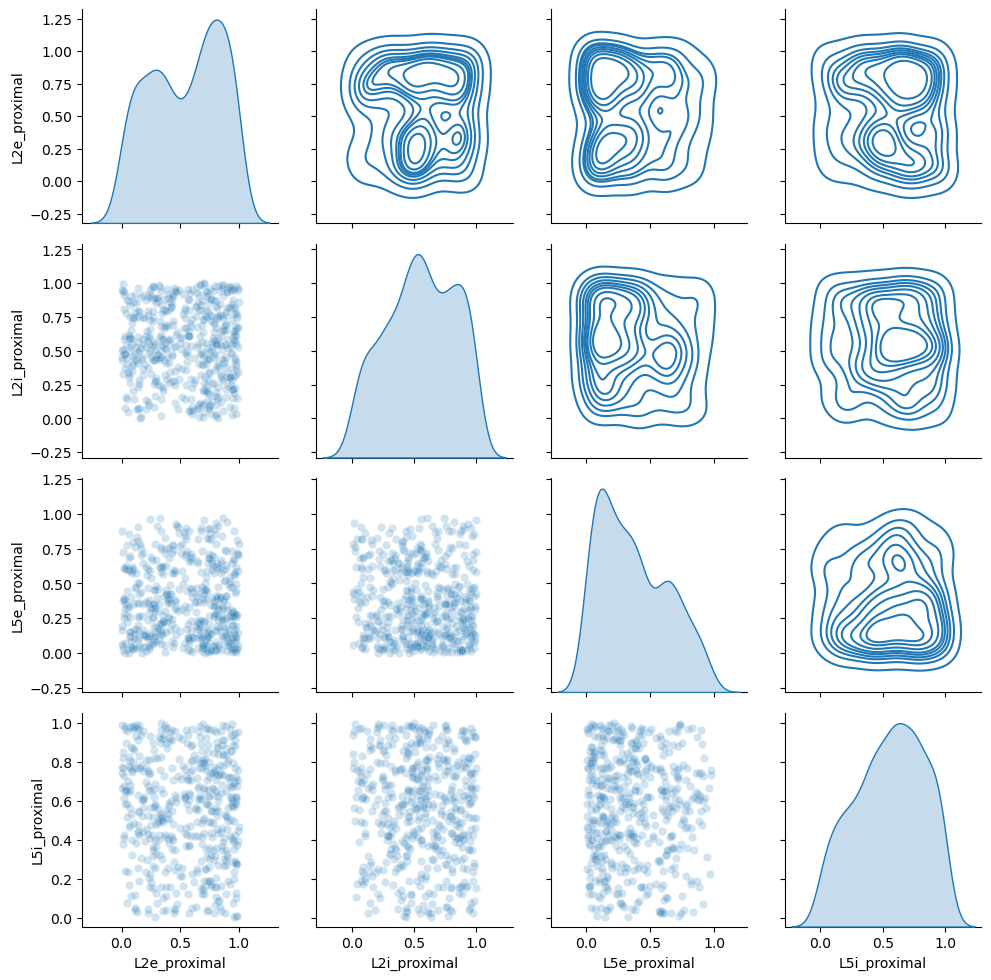

In [35]:
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
g = sns.PairGrid(df[columns[12:16]], diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_upper(sns.kdeplot, fill=False)
g.map_diag(sns.kdeplot, fill=True)